In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")
#print(file.readline()) 

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

#print(lines_after_6[0])

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
    
    
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)
#print(data[0])
#print(len(data))

In [5]:
#split data into batches of 10000 points
batches10000 = [data[x:x+10000] for x in range(0, len(data), 10000)]

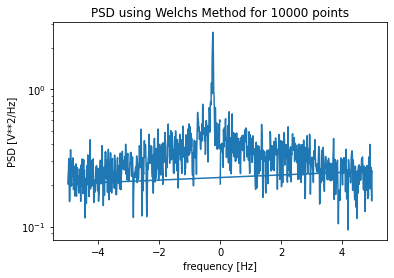

In [6]:
#calculate PSD using welch's method 
fP, Pxx_den = signal.welch(batches10000[0]-np.mean(batches10000[0]), 10, nperseg=1024, return_onesided=False)
plt.semilogy(fP, Pxx_den)
plt.title('PSD using Welchs Method for 10000 points')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

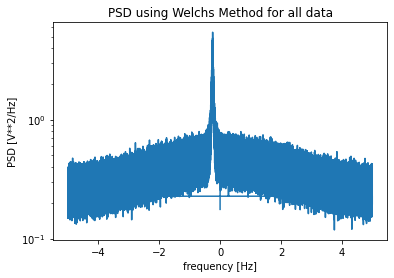

In [7]:
fall, Pxx_all = signal.welch(data-np.mean(data), 10, nperseg=1000000, return_onesided=False)
plt.semilogy(fall, Pxx_all)
plt.title('PSD using Welchs Method for all data')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
#plt.xlim(-0.3,-0.2)
plt.show()

975534
-0.24466000000000002
0.0


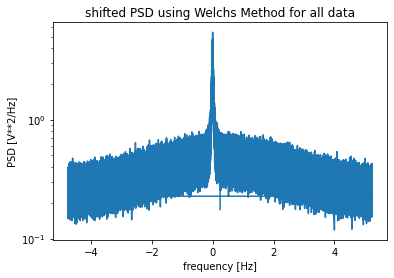

In [8]:
#shift the peak to zero before putting into calibration eqs
maxindex=np.argmax(Pxx_all)
print(maxindex)
shift=fall[maxindex]
fallshift=fall+abs(shift)
print(shift)
#print(fallshift)
print(fallshift[maxindex])

plt.semilogy(fallshift, Pxx_all)
plt.title('shifted PSD using Welchs Method for all data')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
#plt.xlim(-0.3,-0.2)
plt.show()

In [9]:
print(fall[:10])

[0.e+00 1.e-05 2.e-05 3.e-05 4.e-05 5.e-05 6.e-05 7.e-05 8.e-05 9.e-05]


In [10]:
#displacement noise equation from GW Summary 
#Su(omega) =(1/k i omega)^2 * 1/Z^2 * Sv(omega)
#(1/i)^2 = -1
#omega=2pi f

#given SQUID transimpedance 
Zsquid= 1.2e6

#spectral density of voltage noise output by SQUID - convert Sv(f) to Sv(omega)=Sv here
Sv= [x*(1/2*np.pi) for x in Pxx_all]
#print(len(Sv))

#electromechanical coupling constant, this value is in range given in [2] for 10MHz mode
#or using values for 8.392MHz mode given in [3] with estimated M=1g gives order 10^-5, check with prof 
ksquared= 1e-5

#omega frequency axis, convert from Hz to rad/s and square 
omega= [(x+5.505e6)*(2*np.pi) for x in fall]
omegasq= [x**2 for x in omega]

#print(fallshift[0])
#print(fallshift[0]*2*np.pi)
print(omega[0])
print(omega[0]**2)
print(omegasq[0])
#print(len(omegasq))

34588935.11602362
1196394432460492.0
1196394432460492.0


In [11]:
#checking conversion of units from Hz to omega okay
#plt.semilogy(omega, Sv)
#plt.title('shifted PSD in omega')
#plt.xlabel('omega (rad/s)')
#plt.ylabel('PSD [V**2/(rad/s)]')
#plt.xlim(-0.3,-0.2)
#plt.show()

In [12]:
#multiply 1/omega^2 list and Sv 
product= [(1/a) * b for a, b in zip(omegasq, Sv)]
#print(product[0])
#print((1/omegasq[0])*Sv[0])
#note: 1/i^2 makes constants negative 

#put into equation for Su(omega)
constants = -(1/ksquared)*1/(Zsquid**2)
Su = [x*(constants) for x in product]

#check
#print(len(Su))
#print((1/omegasq[200])*Sv[200]*constants)
#print(Su[200])

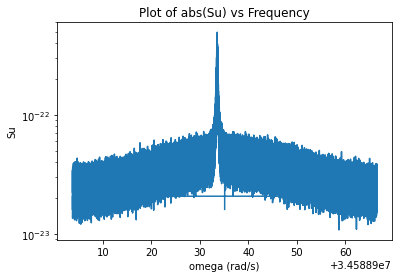

In [13]:
#plot of Su(omega) vs omega

absSu = [abs(x) for x in Su]

plt.semilogy(omega, absSu)
plt.title('Plot of abs(Su) vs Frequency')
plt.xlabel('omega (rad/s)')
plt.ylabel('Su')
plt.show()

In [14]:
#transfer function equation
#H(iomega)= - (xi*ho*omega^2/2) / (iomega)^2 + tau^-1*omega + omega_n^2
#xi = 8/n*pi Erf(sqrt(n)*eta_x)Erf(sqrt(n)*eta_y) / Erf(sqrt(2n)*eta_x)Erf(sqrt(2n)*eta_y)
from scipy import special

eta_x = eta_y = 10
ho = 2.5e-4
tau = 2.1e6**(-1)
n = 3
modeomega= 2*np.pi*5.505e6

xi= (8/n*np.pi)*((special.erf(n**(1/2)*eta_x)*special.erf(n**(1/2)*eta_y))/(special.erf((2*n)**(1/2)*eta_x)*special.erf((2*n)**(1/2)*eta_y)))
omegasqover2 = [x/2 for x in omegasq]
Hnumerator= [x*(-xi*ho) for x in omegasqover2]


iomegasq= [-x for x in omegasq]
invtauomega= [x*(tau**(-1)) for x in omega]

addition = [a+b for a,b in zip(iomegasq, invtauomega)]
#print(iomegasq[10]+invtauomega[10])
#print(add[10])

Hdenom= [x+((modeomega)**2) for x in addition]
#print(addition[10]+modeomega**2)
#print(Hdenom[10])

H= [a/b for a,b in zip(Hnumerator, Hdenom)]

In [15]:
print(iomegasq[:10])
print(iomegasq[0]+((modeomega)**2))
print(invtauomega[0])
print(Hdenom[0])

[-1196394432460492.0, -1196394432464838.5, -1196394432469185.0, -1196394432473531.5, -1196394432477878.5, -1196394432482225.0, -1196394432486571.5, -1196394432490918.0, -1196394432495264.5, -1196394432499611.0]
0.0
72636763743649.61
72636763743649.62


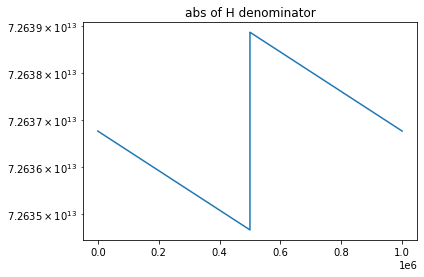

In [16]:
absHdenom= [abs(x) for x in Hdenom]
absHnum= [abs(x) for x in Hnumerator]

#y= [a-b for a,b in zip(absHnum, omegasqover2)]
#plt.semilogy(y)

plt.semilogy(absHdenom)
plt.title('abs of H denominator')
plt.show()

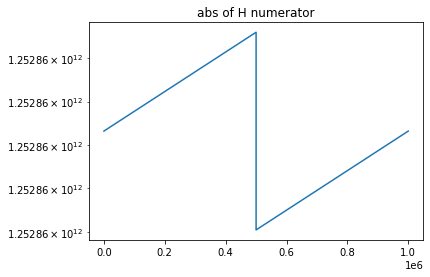

In [17]:
plt.semilogy(absHnum)
plt.title('abs of H numerator')
plt.show()

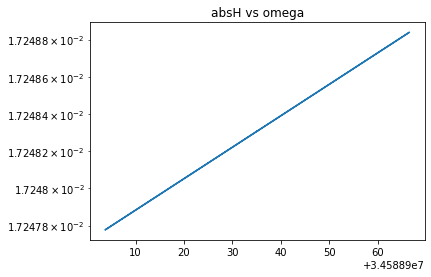

In [18]:
absH= [abs(x) for x in H]

#plt.semilogy(absH)
plt.semilogy(omega, absH)
plt.title('absH vs omega')
plt.show()



In [19]:
import cmath 

#square root of Su values, they are negative due to the 1/i^2 so complex sqrt required
Snumerator= [cmath.sqrt(x) for x in Su]
#print(cmath.sqrt(Su[3000]))  
#print(Snumerator[3000])

#equation denominator is absolute value of H(iomega)
Sdenom = [abs(x) for x in H]

#S= [a/b for a,b in zip(Snumerator, Sdenom)]
#getting error due to a division by zero 

In [20]:
#find zeros in denominator and remove 
#zeros=0

#for i in range(0,len(Sdenom)):
 #   if Sdenom[i] ==0:
 #       zeros += 1
 #       print(i)
#print(zeros)


In [21]:
#Sdenom.remove(0.0)


In [22]:
#check zero removed
zero=0
for i in range(0,len(Sdenom)):
    if Sdenom[i] ==0:
        zero += 1
        print(i)
print(zero)

0


In [23]:
#remove same index for numerator and omega so dimensions match
#Snumerator.pop(975534)
#omega.pop(975534)

In [24]:
S= [a/b for a,b in zip(Snumerator, Sdenom)]

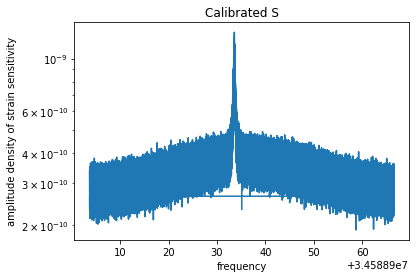

In [25]:
#take abs value for plotting
Sabs= [abs(x) for x in S]

plt.semilogy(omega, Sabs)
plt.title('Calibrated S')
plt.xlabel('frequency')
plt.ylabel('amplitude density of strain sensitivity')
#plt.xlim(-0.3,-0.2)
plt.show()

In [26]:
#try taking complex log of S for plotting 
#clogS= [cmath.log(x) for x in S]

#plt.plot(omega, clogS)
#plt.show()

In [27]:
#print(S[:10])

In [28]:
print(omega[:10])

[34588935.11602362, 34588935.11608645, 34588935.116149284, 34588935.116212115, 34588935.11627495, 34588935.11633778, 34588935.116400614, 34588935.116463445, 34588935.116526276, 34588935.11658911]
